# Raw Data Size Calculator

The following notebook provides a model to calculates the data volume from R1.TEL.EVT and DL0.TEL.EVT data produced on site, and compares it to the limitations of the off-site data link.

* This notebook has interactive elements that do not work in a static NBViewer (like GitHub), so it's best to download a local copy and run it with `jupyter notebook <filename>` or use the on-line interactive instance 
* An [interactive version of this notebook](https://mybinder.org/v2/gh/kosack/cta_exploration/master): 
[![Binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/kosack/cta_exploration/master)


* Author: Karl Kosack <karl.kosack@cea.fr>

In [1]:
%pylab inline
from astropy import units as u
import pandas as pd
from ipywidgets import interact, Layout
from copy import copy

Populating the interactive namespace from numpy and matplotlib


## Assumptions 

Camera Data:
* average trigger rates per subarray are from https://jama.cta-observatory.org/perspective.req#/items/27987?projectId=6

* the array is the *full* CTA-South array, without any staging

* The data sizes are based on the **R1/DL0 interface document** (in prep), where the estimate includes for each subarray type:
  * The DL0.TEL.EVT.IMAGE data (camera readout) with integral readout + a fraction of pixels with pulse readout
  * a single timestamp per camera per event
  * a pixel-wise flag per pixel that can encode e.g. the gain channel selected, as well as pixel trigger info
  * a trigger type flag
* The volume of technical data (MON and SVC) is set as a fixed-value per year.

Off-site link:
* we only transfer data when data are not being taken (maybe this is not needed, but the difference is small)
* we should only use at most 75% of the off-site link 

Transfer Rates:
* the *mean transfer rate* assumes an average over all non-data-taking time in a year
* the *peak transfer rate* is calculated for a single long night of 12h of observations, and assumes continuous copying (even during data taking) for 24 hours
* the *mean transfer rate* should be between 50%-75% of the total link speed, and the *peak transfer rate* should not greatly exceed the full link speed (since it is only at peak occasionally during the year).  


In [2]:
subarrays = {}

subarrays['LST'] = dict(
    n_pix = 1855,
    # note according to Konrad, with the "Aggressive" trigger scheme, 
    # this can be as low as 5376.9 Hz
    rate = 15000 * u.Hz,  
    mean_tels_triggered = 2.6,
)

subarrays['MST'] = dict(
    n_pix = 1855,
    rate = 7000 * u.Hz,
    mean_tels_triggered = 7,
)

subarrays['SST'] = dict(
    n_pix = 2048,
    rate = 600 * u.Hz,
    mean_tels_triggered = 7,
)

obs_per_year = 1314 * u.h
obs_per_night_peak = 12*u.h

mon_data_per_year = 100 *u.TB # from CTA Off-site IC infrastructure costs estimate, V3.3

off_site_link_speed = 1 *u.Gbit/u.s

pd.DataFrame(subarrays)

,LST,MST,SST
mean_tels_triggered,2.6,7,7
n_pix,1855,1855,2048
rate,15000.0 Hz,7000.0 Hz,600.0 Hz


## Calculation

In [3]:
def subarray_rate(subarray=subarrays, 
                  event_id_size=64*u.bit, 
                  timestamp_size=2*32*u.bit, 
                  trig_type_size=8*u.bit, 
                  pix_status_size=8*u.bit, 
                  dvr_percent_waveform=3.0,
                  dvr_percent_integrated=0,
                  pix_sample_size=16*u.bit,
                  pix_integrated_size=16*u.bit, # enough?
                  compression_ratio=4.0,
                  num_gain_channels=1,
                  n_samp=64):
    
    dvr_fraction_waveform = dvr_percent_waveform/100.0
    dvr_fraction_integrated = dvr_percent_integrated/100.0
    core_size = event_id_size + timestamp_size + trig_type_size 
    pix_flag_size = pix_status_size * subarray['n_pix']
    
    # images with + without DVR:
    image_size = pix_sample_size * subarray['n_pix'] * n_samp * dvr_fraction_waveform
    image_size += pix_integrated_size * subarray['n_pix'] * dvr_fraction_integrated # integrated pixels
    image_size *= num_gain_channels

    event_size =  core_size + pix_flag_size + image_size
    
    data_rate = (event_size 
                 * subarray['rate'] 
                 * subarray['mean_tels_triggered']) / compression_ratio 
    
    return data_rate

def combined_data_rate(subarrays, **params):
    """ rate for all subarrays summed """
    rates = [subarray_rate(x, **params).to('Gbit/s').value for x in subarrays.values()]
    return np.sum(rates) * u.Gb/u.s

def colorizer(val):
    """ warn if the off-site link is saturated """
    speed = off_site_link_speed.to('Gbit/s').value

    if val < (0.5 * speed):
        color = 'green'
    elif val > (0.5 * speed) and val < (0.7 * speed):
        color = 'orange'
    elif val > (0.7 * speed):
        color = 'red'
    return 'color: %s; font-weight:bold' % color

In [4]:
def calc_rates(subarrays=subarrays, **params):
    """ 
    put all estimates into a Pandas DataFrame, and calculate 
    yearly rates and transfer rates 
    """
    r1params = copy(params)
    r1params['dvr_percent_waveform'] = 100
    r1params['dvr_percent_integrated'] = 0
    r1params ['compression_ratio'] = 1.0

    mon_rate = (mon_data_per_year/u.yr).to('Gbyte/s').value
    results = pd.DataFrame( index=list(subarrays.keys()) + ['MON'])
    results['rate_R1_Gbps'] = [subarray_rate(x, **r1params).to('Gbit/s').value 
                               for x in subarrays.values()] +[mon_rate,]
    results['rate_DL0_Gbps'] = [subarray_rate(x, **params).to('Gbit/s').value 
                                for x in subarrays.values()] + [mon_rate,]
    results['volume_1yr_PB'] = (results['rate_DL0_Gbps'].data * u.Gbit/u.s * obs_per_year).to('PB')
    results['volume_5yr_PB'] = (results['rate_DL0_Gbps'].data * u.Gbit/u.s * 5 * obs_per_year).to('PB')
    results['volume_10yr_PB'] = (results['rate_DL0_Gbps'].data * u.Gbit/u.s * 10* obs_per_year).to('PB')
    results['mean_transfer_Gbps'] = (results['volume_1yr_PB'].data * u.PB / 
                                     (1.0*u.yr - obs_per_year)).to('Gbit/s')
    results['peak_transfer_Gbps'] = (((results['rate_DL0_Gbps'].data * u.Gbit/u.s) 
                                      * obs_per_night_peak) / (24*u.h)).to('Gbit/s')
    results.loc['TOTAL'] = results.sum()
    return results.style.applymap(colorizer, subset=['mean_transfer_Gbps','peak_transfer_Gbps'])

## Results

### base scenario

In [5]:
results = calc_rates()
results

,rate_R1_Gbps,rate_DL0_Gbps,volume_1yr_PB,volume_5yr_PB,volume_10yr_PB,mean_transfer_Gbps,peak_transfer_Gbps
LST,74.6653,0.701626,0.414871,2.07436,4.14871,0.123717,0.350813
MST,93.8103,0.88153,0.521248,2.60624,5.21248,0.155439,0.440765
SST,8.87742,0.0834063,0.0493181,0.246591,0.493181,0.0147069,0.0417031
MON,0.00316881,0.00316881,0.00187372,0.00936858,0.0187372,0.000558751,0.0015844
TOTAL,177.356,1.66973,0.987312,4.93656,9.87312,0.294421,0.834865


note all rates are in *Gbit/s* and the **CTA max transfer rate off-site is 1 Gb/s**, so the *mean_transfer_Gbps* column should be $< 1 Gbit/s$

### Scenario 2: increase DVR fraction to keep 10% of pixels

what if we keep 10% of the camera after DVR, instead of the default 3% of pixels?

In [6]:
calc_rates(dvr_percent_waveform=10.0, dvr_percent_integrated=0) 

,rate_R1_Gbps,rate_DL0_Gbps,volume_1yr_PB,volume_5yr_PB,volume_10yr_PB,mean_transfer_Gbps,peak_transfer_Gbps
LST,74.6653,1.99805,1.18145,5.90723,11.8145,0.352313,0.999024
MST,93.8103,2.51037,1.48438,7.4219,14.8438,0.442649,1.25518
SST,8.87742,0.237547,0.140462,0.702308,1.40462,0.0418863,0.118773
MON,0.00316881,0.00316881,0.00187372,0.00936858,0.0187372,0.000558751,0.0015844
TOTAL,177.356,4.74913,2.80816,14.0408,28.0816,0.837407,2.37457


here, we exceed the transfer rate (over 75% of the link must be used in non-data-taking time), so this is not a reasonable solution

### Scenario 3: Read out 2 gain channels

Let's try another scenario: assume that the telescopes read out *both gain channels* 

In [7]:
calc_rates(num_gain_channels=2)

,rate_R1_Gbps,rate_DL0_Gbps,volume_1yr_PB,volume_5yr_PB,volume_10yr_PB,mean_transfer_Gbps,peak_transfer_Gbps
LST,148.747,1.25724,0.743403,3.71702,7.43403,0.221686,0.628618
MST,186.887,1.5796,0.934019,4.6701,9.34019,0.278529,0.789802
SST,17.6855,0.149467,0.0883796,0.441898,0.883796,0.0263552,0.0747333
MON,0.00316881,0.00316881,0.00187372,0.00936858,0.0187372,0.000558751,0.0015844
TOTAL,353.322,2.98947,1.76768,8.83838,17.6768,0.527129,1.49474


The result is that we are nearing the danger level of the link transfer speed (over half of the capacity used for just raw camera data), and the peak transfer is nearly 2x the requirement

### show the difference between 2 scenarios

scenario where we store 2 gain channels

In [8]:
(calc_rates(num_gain_channels=2).data - calc_rates().data).add_prefix('d_')

,d_rate_R1_Gbps,d_rate_DL0_Gbps,d_volume_1yr_PB,d_volume_5yr_PB,d_volume_10yr_PB,d_mean_transfer_Gbps,d_peak_transfer_Gbps
LST,74.081280,0.555610,0.328532,1.642660,3.285320,0.097970,0.277805
MST,93.076480,0.698074,0.412771,2.063855,4.127709,0.123090,0.349037
SST,8.808038,0.066060,0.039061,0.195307,0.390614,0.011648,0.033030
MON,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TOTAL,175.965798,1.319743,0.780364,3.901822,7.803643,0.232708,0.659872


scenario where we keep the integral of all pixels always:

In [9]:
(calc_rates(dvr_percent_integrated=100).data - calc_rates().data).add_prefix('d_')

,d_rate_R1_Gbps,d_rate_DL0_Gbps,d_volume_1yr_PB,d_volume_5yr_PB,d_volume_10yr_PB,d_mean_transfer_Gbps,d_peak_transfer_Gbps
LST,0.0,0.289380,0.171110,0.855552,1.711104,0.051026,0.144690
MST,0.0,0.363580,0.214985,1.074924,2.149849,0.064110,0.181790
SST,0.0,0.034406,0.020345,0.101723,0.203445,0.006067,0.017203
MON,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TOTAL,0.0,0.687366,0.406440,2.032199,4.064398,0.121202,0.343683


## Interactive Exploration

use the code below (running in a real Jupyter notebook, not NBViewer) to have an interactive widget version to try out other scenarios in realtime.

In [10]:
@interact(waveform=(0.0,100.0,1), 
          integrated=(0.0,100.0,1),
          compression_ratio=(1,4,0.1), 
          pix_integrated_size=[16*u.bit, 32*u.bit],
          pix_status_size=[0*u.bit, 8*u.bit, 16*u.bit],
          num_gain_channels=[1,2], n_samp=(0,128,1))
def explore(waveform=3.0, integrated=0,
            compression_ratio=3, 
            pix_integrated_size=16*u.bit,
            pix_status_size=8*u.bit, 
            num_gain_channels=1, n_samp=64):
    return calc_rates(dvr_percent_waveform=waveform, 
                      dvr_percent_integrated=integrated,
                      compression_ratio=compression_ratio,
                      pix_integrated_size=pix_integrated_size,
                      pix_status_size=pix_status_size, 
                      num_gain_channels=num_gain_channels, n_samp=n_samp)

interactive(children=(FloatSlider(value=3.0, description='waveform', step=1.0), FloatSlider(value=0.0, description='integrated', step=1.0), FloatSlider(value=3.0, description='compression_ratio', max=4.0, min=1.0), Dropdown(description='pix_integrated_size', options=(<Quantity 16.0 bit>, <Quantity 32.0 bit>), value=<Quantity 16.0 bit>), Dropdown(description='pix_status_size', index=1, options=(<Quantity 0.0 bit>, <Quantity 8.0 bit>, <Quantity 16.0 bit>), value=<Quantity 8.0 bit>), Dropdown(description='num_gain_channels', options=(1, 2), value=1), IntSlider(value=64, description='n_samp', max=128), Output()), _dom_classes=('widget-interact',))

## What about the DL0.SUB.EVT (central trigger) data?

does it respresent a large fraction?

In [11]:
system_trigger_rate = 15_000 *u.Hz
trigger_pattern = 128*u.bit 
timestamp_size = 64*u.bit

dl0_sub_evt_rate = system_trigger_rate * (trigger_pattern + timestamp_size)
dl0_sub_evt_rate.to("Gbit/s")

<Quantity 0.00288 Gbit / s>

this is a small fraction of the DL0 size:

In [12]:
dl0_sub_evt_frac = (dl0_sub_evt_rate/combined_data_rate(subarrays)).to(u.dimensionless_unscaled)
dl0_sub_evt_frac * 100 * u.percent

<Quantity 0.17281090561238266 %>

In [13]:
(3*u.PB/u.yr * dl0_sub_evt_frac).to("TB/yr")

<Quantity 5.18432716837148 Tbyte / yr>

So we should add about this amount to the final data estimate to include the subarray event data

## Some useful parameter space plots

In [14]:
# a hack to get just the final value (this is not very speed friendly!)
@np.vectorize
def transfer_rate(**params):
    df = calc_rates(**params)
    return df.data.loc['TOTAL']['mean_transfer_Gbps'], df.data.loc['TOTAL']['peak_transfer_Gbps']

In [15]:
n_samp = np.linspace(0,128,32)
dvr_percent = np.linspace(0,50,21)
N,D = np.meshgrid(n_samp, dvr_percent)

In [16]:
def plot_scenario(name, Rm, Rp):
    figure(figsize=(10,5), dpi=100)

    subplot(1,2,1)

    xlabel("Mean percent pixels with waveform")
    ylabel("$N_{samp}$ read out")
    cs = contour(D, N, Rm, levels=[0.5, 0.75,1,2,5], colors=['green','orange','red', 'red','red'])
    clabel(cs, cs.levels, labels=["{} Gb/s".format(x) for x in cs.levels])
    grid(True)
    title("DL0 transfer rate (mean), Gbit/s")

    subplot(1,2,2)

    xlabel("Mean percent pixels with waveform")
    ylabel("$N_{samp}$ read out")
    cs = contour(D, N, Rp, levels=[0.5, 0.75,1,2,5], colors=['green','orange','red', 'red','red'])
    clabel(cs, cs.levels, labels=["{} Gb/s".format(x) for x in cs.levels])
    grid(True)
    title("DL0 transfer rate (peak), Gbit/s")

    suptitle(name)
    #plt.tight_layout()

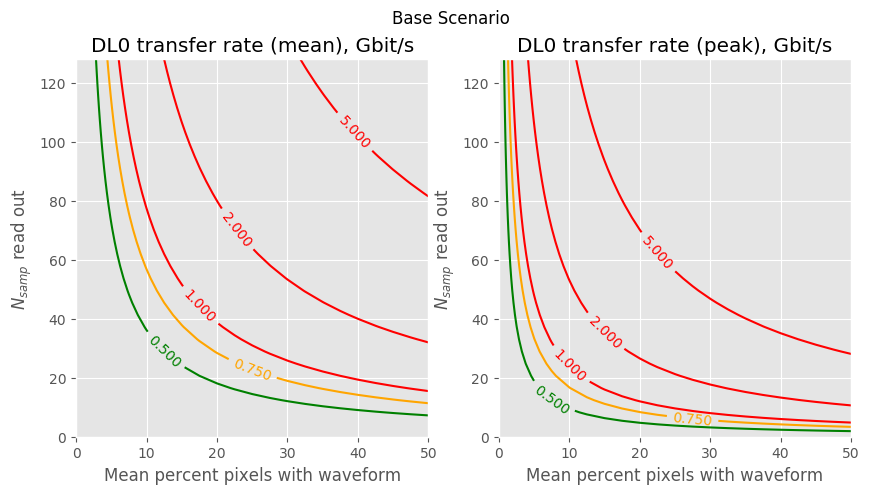

In [17]:
plt.style.use("ggplot")
Rm,Rp = transfer_rate(dvr_percent_waveform=D, n_samp=N )
plot_scenario("Base Scenario", Rm, Rp)

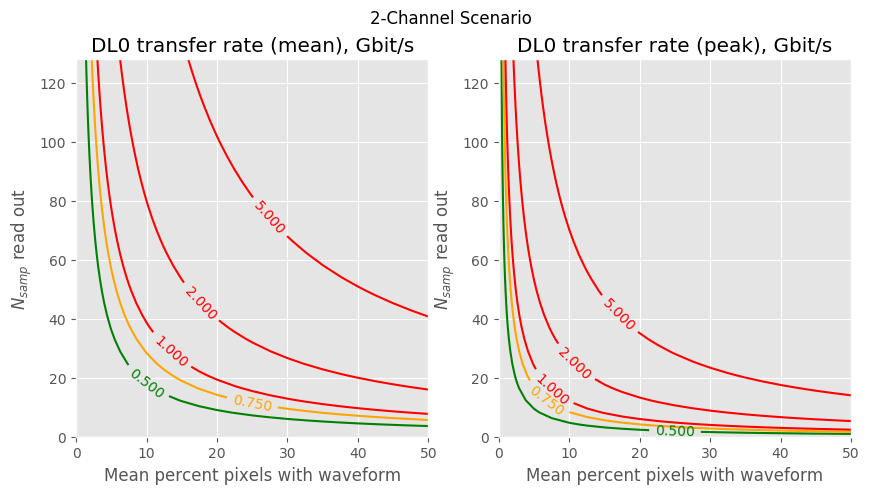

In [18]:
plt.style.use("ggplot")
Rm,Rp = transfer_rate(dvr_percent_waveform=D, n_samp=N, num_gain_channels=2 )
plot_scenario("2-Channel Scenario", Rm, Rp)